<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Задача:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час..

**Критерий оценки:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [3]:
#выведем первые 5 строк датафрейма
data.head()

In [4]:
#посмотрим общую информаицю о датасете
data.info()

## Анализ

In [5]:
#выполним ресемплирование по одному часу
data = data.resample('1H').sum()
data

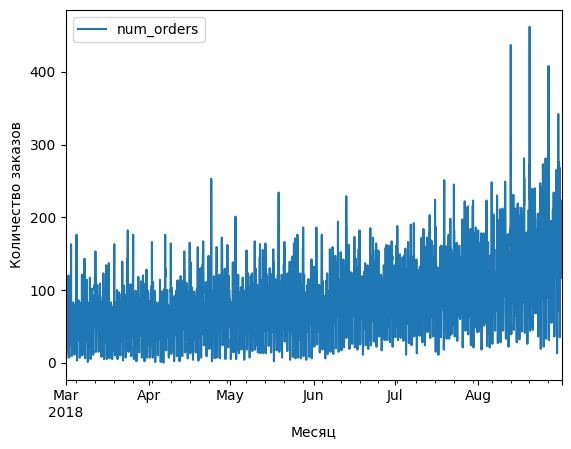

In [6]:
#построим график
ax=data.plot()
plt.xlabel('Месяц')
plt.ylabel('Количество заказов');

Чтобы снизить колебания применим скользящее среднее, равное 24 (т.е. сутки):

In [7]:
data['rolling_mean'] = data.rolling(24).mean()

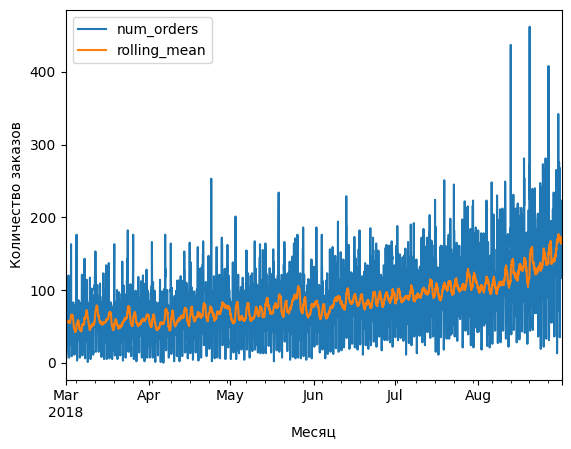

In [8]:
ax = data.plot()
plt.xlabel('Месяц')
plt.ylabel('Количество заказов');

Посмотрим на тренды и сезонность:

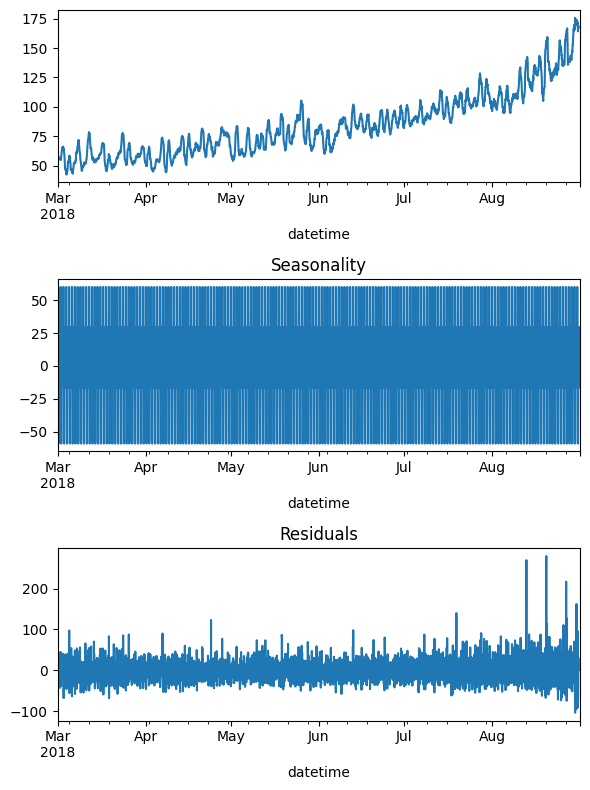

In [9]:
decomposed = seasonal_decompose(data['num_orders']) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По тренду мы видим, что с середины июня количество заказов увеличивается. Чтобы оценить сезонность посмотрим на данные за 1 день:

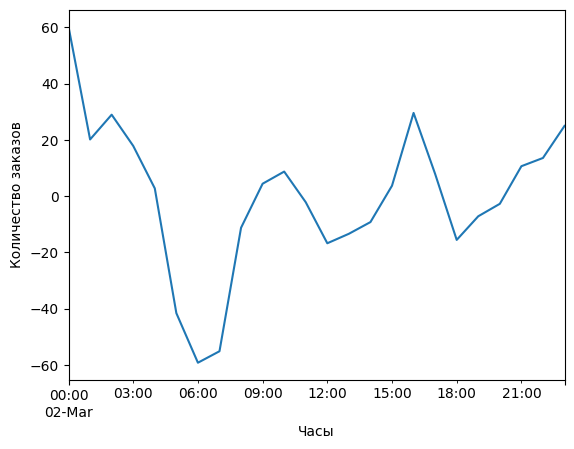

In [10]:
#за один день в марте
ax = decomposed.seasonal['2018-03-02':'2018-03-02'].plot(ax=plt.gca())
plt.xlabel('Часы')
plt.ylabel('Количество заказов');

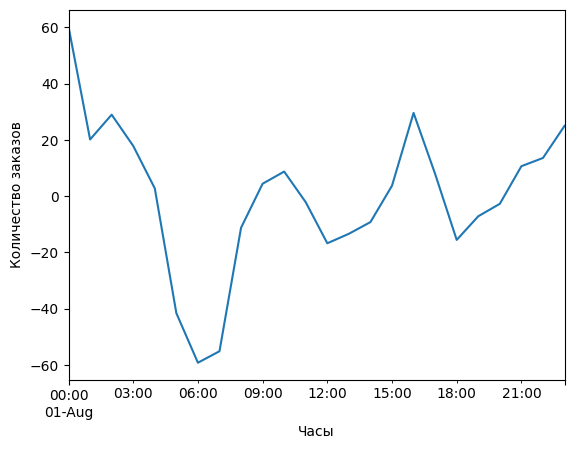

In [11]:
#за один день в августе
ax = decomposed.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.xlabel('Часы')
plt.ylabel('Количество заказов');

Мы видим, что количество заказов  в 6 утра начинает расти до 9 утра(рабочее время), следующий пик в 16.00 и подъем в 18 вечера (послерабочее время).

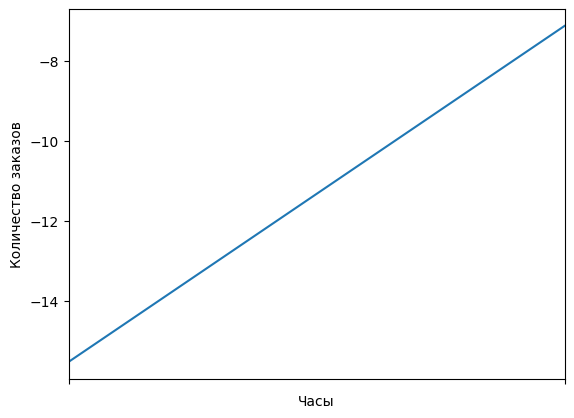

In [12]:
#за один час вечером
ax = decomposed.seasonal['2018-03-02 18:00:00':'2018-03-02 19:00:00'].plot(ax=plt.gca())
plt.xlabel('Часы')
plt.ylabel('Количество заказов');

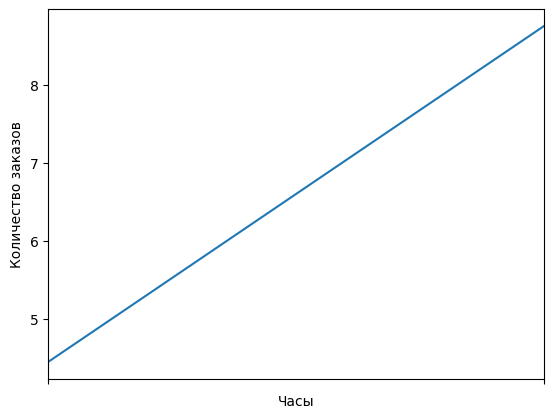

In [13]:
#за один час утром
ax = decomposed.seasonal['2018-03-02 09:00:00':'2018-03-02 10:00:00'].plot(ax=plt.gca())
plt.xlabel('Часы')
plt.ylabel('Количество заказов');

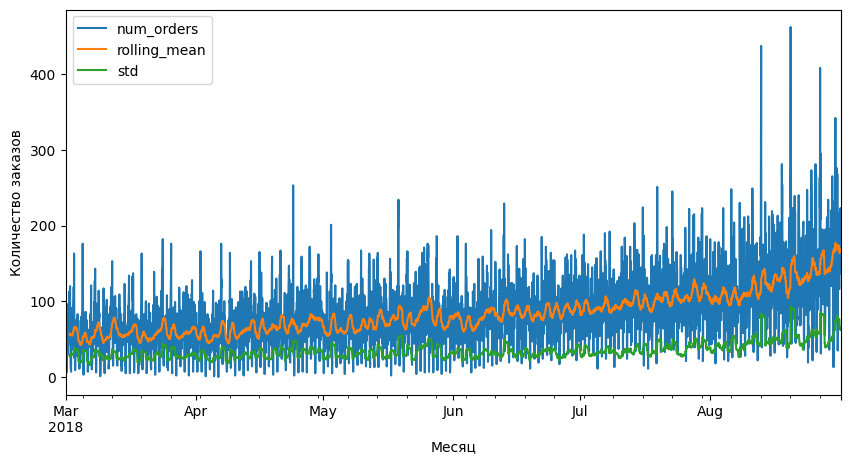

In [15]:
#найдём скользящее стандартное отклонение
data['std'] = data['num_orders'].rolling(24).std()
ax = data.plot(figsize = (10,5)) 
plt.xlabel('Месяц')
plt.ylabel('Количество заказов');

Чем медленнее меняется среднее и стандартное отклонение, тем временной ряд «более стационарный». На нашем графике эти значения меняются небыстро.

Удалим столбцы, которые нам нужны были для анализа и добавим новые признаки после разделения на выборки.

In [16]:
data = data.drop(['rolling_mean', 'std'], axis=1)

***Вывод:***

На данном этапе мы:
- измененили интервал на 1 час
- выявили тренд, что с середины июня заказы начинают увеличиваться
- в 9 утра и в 18 вечера количество заказов растёт и спадает после 12 часов ночи, также есть пик заказов в 16.00

## Обучение

### Создание признаков

In [17]:
#напишем функцию для создания признаков
def make_features(data, max_lag,rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
#поделим датасет на обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [19]:
#создадим признаки в обучающей выборке
make_features(train, 24, 24)
train

In [20]:
#удалим пропущенные значения
train = train.dropna()

In [21]:
#создадим признаки в тестовой выборке
make_features(test, 24, 24)
test

In [22]:
#удалим пропуски
test = test.dropna()

In [23]:
#разобъем на признаки
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

In [24]:
#посмотрим на размер выборок
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

### Обучение моделей

Так как нам необходимо сохранить временную структуру при кросс-валидации, воспользуемся TimeSeriesSplit:


In [25]:
tscv = TimeSeriesSplit(n_splits=8)

#### LGBMRegressor

In [26]:
%%time

estimator = lgb.LGBMRegressor()
grid_params = {
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': range(-1, 10),
    'n_estimators': range(100, 501, 100),
}
gbm = GridSearchCV(estimator, grid_params, scoring ='neg_root_mean_squared_error',n_jobs=-1, cv=tscv, verbose=1)
gbm.fit(features_train, target_train)
gbm_best_score = gbm.best_score_ *(-1)
print(gbm.best_estimator_)
print(gbm_best_score)
print(gbm.best_params_)

#### CatBoostRegressor

In [27]:
%%time

cbr = CatBoostRegressor()


grid_param = {'max_depth': [3,4,5],'n_estimators':range(100, 500, 100)}
gs_cbr = GridSearchCV \
(estimator = cbr, param_grid = grid_param, scoring ='neg_root_mean_squared_error',n_jobs=-1, cv=tscv, verbose=1)
gs_cbr.fit(features_train,target_train)
gs_cbr_best_score = gs_cbr.best_score_ *(-1)

print(gs_cbr.best_estimator_)
print(gs_cbr_best_score)
print(gs_cbr.best_params_)

#### RandomForestRegressor

In [28]:
%%time

best_model_forest = None
best_result_forest = 0
best_est_forest = 0
for est in range(300,500,50):
    model_forest = \
    RandomForestRegressor(random_state=12345, \
    n_estimators= est)
    scores_forest = \
    cross_val_score(model_forest, features_train, target_train,  scoring='neg_root_mean_squared_error', cv=tscv)
    rmse_forest = scores_forest.mean() * (-1)
    if rmse_forest > best_result_forest:
        best_model_forest = model_forest
        best_result_forest = rmse_forest
        best_est_forest = est
print ("Количество деревьев:", best_est_forest) 
print ("Средняя оценка RMSE для случайного леса:",\
       best_result_forest)

#### LinearRegression

In [29]:
#стандартизируем данные для линейной регрессии
scaler = StandardScaler()
scaler.fit(features_train)
features_train_ss = scaler.transform(features_train)
features_train_ss

In [30]:
%%time

model_lr = LinearRegression()
scores_lr = \
cross_val_score(model_lr, features_train_ss, target_train,  scoring='neg_root_mean_squared_error', cv=tscv) 
rmse_lr = scores_lr.mean() * (-1)
print ("Средняя оценка RMSE для линейной регресии:",\
       rmse_lr)

Объединим результат в таблицу для выбора лучшей модели:

In [31]:
result = {'model_name':\
['LGBMRegressor','CatBoostRegressor','RandomForestRegressor', 'LinearRegression'],\
'RMSE':[gbm_best_score, gs_cbr_best_score,best_result_forest,rmse_lr]}
result = pd.DataFrame(result)
result.\
sort_values(by='RMSE').\
reset_index(drop = True)

Лучший результат показала модель CatBoostRegressor, с помощью нее проверим данные на тестовой выборке.

## Тестирование

In [32]:
cbr_test_pred = pd.Series(gs_cbr.predict(features_test), index = target_test.index)
result_test_cbr = mean_squared_error(target_test, cbr_test_pred) ** 0.5
print('RMSE на тестовой выборке:', result_test_cbr)

Значение метрики RMSE соответствует заявленным требованиям.

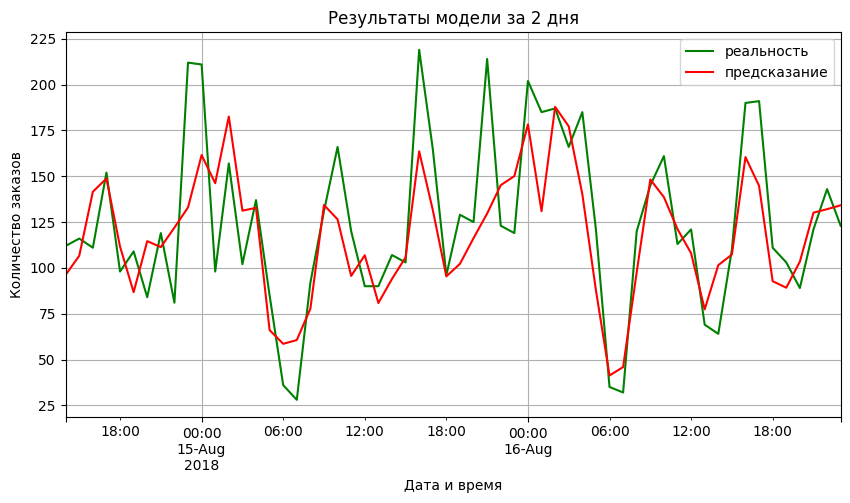

In [37]:
#посторим график
plt.figure(figsize=(10,5))
target_test['2018-08-14':'2018-08-16'].plot(label='реальность', color = 'green')
cbr_test_pred['2018-08-14':'2018-08-16'].plot(label='предсказание',  color = 'red')
plt.title('Результаты модели за 2 дня')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid()
plt.legend()
plt.show()

## Общий вывод

В данном исследовании мы выполнили следующие шаги:
  - проанализировали данные, выявили тренд и сезонность
  - разделили данные на обучающую и тестовую выборку, создали новые признаки
  - обучили модели: LGBMRegressor, CatBoostRegressor, RandomForestRegressor и LinearRegression 
  - лучший результат метрики показа модель CatBoostRegressor (RMSE = 23.842792)
  - провели тестирование лучшей модели и получили результат: RMSE = 42.18424209236759, что соответствует заявленным требованиям.